In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse
theta = 0.5 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 800000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

40000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

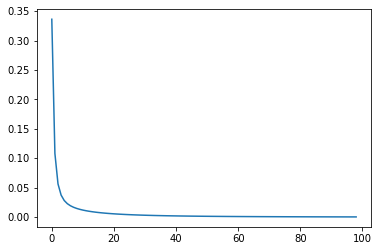

In [8]:
plt.plot(S)

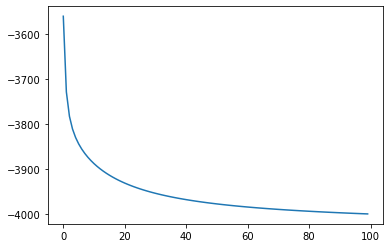

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0005249664670491257

In [11]:
eta

array([-3560.41335429, -3728.46804769, -3782.62858634, -3810.8768475 ,
       -3829.66361754, -3843.86223548, -3855.37761273, -3865.1163494 ,
       -3873.57550215, -3881.05746058, -3887.7612169 , -3893.8259067 ,
       -3899.3535554 , -3904.42185931, -3909.09180971, -3913.4124744 ,
       -3917.4241272 , -3921.16037292, -3924.64963732, -3927.91624153,
       -3930.98119632, -3933.86280223, -3936.57711194, -3939.13829261,
       -3941.55891432, -3943.85018269, -3946.02212888, -3948.08376634,
       -3950.0432215 , -3951.90784353, -3953.68429738, -3955.37864308,
       -3956.99640375, -3958.54262439, -3960.02192277, -3961.4385338 ,
       -3962.79634839, -3964.09894754, -3965.34963243, -3966.55145095,
       -3967.70722137, -3968.81955328, -3969.89086628, -3970.92340679,
       -3971.91926299, -3972.88037832, -3973.80856356, -3974.70550785,
       -3975.57278848, -3976.41187988, -3977.22416169, -3978.01092617,
       -3978.77338481, -3979.51267453, -3980.22986311, -3980.9259544 ,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([4.38986646e+02, 2.70931952e+02, 2.16771414e+02, 1.88523153e+02,
       1.69736383e+02, 1.55537765e+02, 1.44022387e+02, 1.34283651e+02,
       1.25824498e+02, 1.18342539e+02, 1.11638783e+02, 1.05574093e+02,
       1.00046445e+02, 9.49781408e+01, 9.03081904e+01, 8.59875257e+01,
       8.19758729e+01, 7.82396271e+01, 7.47503627e+01, 7.14837585e+01,
       6.84188037e+01, 6.55371978e+01, 6.28228881e+01, 6.02617075e+01,
       5.78410857e+01, 5.55498174e+01, 5.33778712e+01, 5.13162337e+01,
       4.93567786e+01, 4.74921565e+01, 4.57157027e+01, 4.40213570e+01,
       4.24035963e+01, 4.08573757e+01, 3.93780773e+01, 3.79614663e+01,
       3.66036517e+01, 3.53010525e+01, 3.40503676e+01, 3.28485491e+01,
       3.16927787e+01, 3.05804468e+01, 2.95091338e+01, 2.84765933e+01,
       2.74807371e+01, 2.65196217e+01, 2.55914365e+01, 2.46944922e+01,
       2.38272116e+01, 2.29881202e+01, 2.21758384e+01, 2.13890739e+01,
       2.06266152e+01, 1.98873255e+01, 1.91701369e+01, 1.84740457e+01,
      

In [14]:
ql

array([0.00799556, 0.01535183, 0.02211992, 0.02834687, 0.03407594,
       0.03934693, 0.04419649, 0.04865829, 0.05276334, 0.05654018,
       0.06001503, 0.06321206, 0.06615346, 0.06885968, 0.07134952,
       0.07364029, 0.07574789, 0.07768698, 0.07947103, 0.08111244,
       0.08262261, 0.08401203, 0.08529035, 0.08646647, 0.08754855,
       0.08854412, 0.08946008, 0.0903028 , 0.09107815, 0.0917915 ,
       0.09244782, 0.09305165, 0.09360721, 0.09411835, 0.09458862,
       0.09502129, 0.09541937, 0.09578562, 0.09612258, 0.0964326 ,
       0.09671783, 0.09698026, 0.09722171, 0.09744385, 0.09764823,
       0.09783626, 0.09800927, 0.09816844, 0.09831488, 0.09844961,
       0.09857358, 0.09868763, 0.09879256, 0.0988891 , 0.09897792,
       0.09905964, 0.09913483, 0.09920401, 0.09926765, 0.09932621,
       0.09938008, 0.09942965, 0.09947525, 0.09951721, 0.09955581,
       0.09959132, 0.099624  , 0.09965406, 0.09968172, 0.09970717,
       0.09973058, 0.09975212, 0.09977194, 0.09979018, 0.09980

In [15]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

In [16]:
ql/B_valley

array([0.000106  , 0.00016338, 0.00021255, 0.00025466, 0.00029112,
       0.00032293, 0.00035081, 0.00037533, 0.00039693, 0.00041599,
       0.0004328 , 0.00044764, 0.00046072, 0.00047224, 0.00048237,
       0.00049126, 0.00049905, 0.00050583, 0.00051173, 0.00051683,
       0.00052121, 0.00052495, 0.00052812, 0.00053076, 0.00053294,
       0.00053471, 0.0005361 , 0.00053716, 0.00053791, 0.0005384 ,
       0.00053865, 0.00053868, 0.00053852, 0.00053818, 0.0005377 ,
       0.00053708, 0.00053634, 0.0005355 , 0.00053456, 0.00053354,
       0.00053245, 0.0005313 , 0.00053009, 0.00052884, 0.00052754,
       0.00052622, 0.00052486, 0.00052348, 0.00052208, 0.00052067,
       0.00051924, 0.00051781, 0.00051637, 0.00051492, 0.00051348,
       0.00051204, 0.0005106 , 0.00050917, 0.00050774, 0.00050632,
       0.00050491, 0.00050351, 0.00050212, 0.00050074, 0.00049937,
       0.00049801, 0.00049667, 0.00049534, 0.00049402, 0.00049271,
       0.00049142, 0.00049015, 0.00048889, 0.00048764, 0.00048

In [17]:
# save csv files

np.savetxt('elevation csv files/eta_default.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_default.csv', alpha, delimiter = ',')